In [1]:
import os
import cv2
from time import time
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random
from dask import delayed

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

In [3]:
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature

In [296]:
from logistic import logistic_fit, logistic, logistic_prob

In [4]:
import dill

In [61]:
dill.dump_session('01_06_env.db')

In [46]:
t_start = time()
dill.load_session('01_05_env.db')
time() - t_start

75290.20285177231

In [234]:
np.savetxt("X_haar.csv", Xt, delimiter=",")

# Helper Methods

In [115]:
def proportion_b(facenames, n):
    count = 0
    for i in range(n):
        if int(facenames[i].split('_')[3]) == 0:
            count += 1
    return count / n

In [14]:
@delayed
def extract_feature_image(img, feature_type, feature_coord=None):
    """Extract the haar feature for the current image"""
    img = cv2.resize(img, (36,36))
    ii = integral_image(img)
    return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                             feature_type=feature_type,
                             feature_coord=feature_coord)

In [116]:
for f in [face_filenames0, face_filenames25, face_filenames50, face_filenames75, face_filenames100]:
    print(proportion_b(f, n))

1.0
0.7502487562189055
0.5
0.24975124378109453
0.0


In [72]:
def getimgs(facefiles, nonfaces, n):
    faces = []
    for i in range(n):
        faces.append(cv2.imread(facefiles[i], cv2.IMREAD_GRAYSCALE))
    return faces + nonfaces[:n]

In [71]:
def getx(facefiles, n):
    ims = getimgs(facefiles, n)
    X = delayed(extract_feature_image(img, feature_types) for img in ims)
    return np.array(X.compute(scheduler='threads'))

In [150]:
def getx2(facefiles, n, nonfaces, feature_types, feature_coords):
    ims = getimgs(facefiles, nonfaces, n)
    X = delayed(extract_feature_image(img, feature_types, feature_coords) for img in ims)
    return np.array(X.compute(scheduler='threads'))

In [77]:
n, len(nonfaces)

(4020, 4020)

# Feature selection

In [5]:
test_face_names = sorted(glob(os.path.join('data/tests', '*.jpg')))
n_test = len(test_face_names)

In [6]:
b_inds = []
w_inds = []
for i in range(len(test_face_names)):
    if int(test_face_names[i].split('_')[2]) is 0: # race is white
        w_inds.append(i)
    else:
        b_inds.append(i)

In [7]:
test_nonface_names = sorted(glob(os.path.join('data/testing_nonfaces', '*.jpg')))
n_nonfaces_test = len(test_nonface_names)

In [8]:
faces_t = []
for i in range(n_test):
    faces_t.append(cv2.imread(test_face_names[i], cv2.IMREAD_GRAYSCALE))

In [9]:
nonfaces_t = []
for i in range(n_test):
    # Read a random nonface file
    j = random.randint(0, n_nonfaces_test - 1)
    nonface = cv2.imread(test_nonface_names[j], cv2.IMREAD_GRAYSCALE)
    
    wsize = random.randint(36, min(nonface.shape[0], nonface.shape[1]))
    row = random.randint(0, nonface.shape[0]-wsize)
    col = random.randint(0, nonface.shape[1]-wsize)
    crop = nonface[row:row+wsize, col:col+wsize]

    # Resize to be the right size
    crop = cv2.resize(crop, (200, 200))
    nonfaces_t.append(crop)

In [10]:
images_t = faces_t + nonfaces_t
len(images_t)

600

In [11]:
feature_types = ['type-2-x', 'type-2-y', 'type-3-x', 'type-3-y']

In [16]:
t_start = time()
Xf_t = delayed(extract_feature_image(img, feature_types) for img in images_t)
Xf_t = np.array(Xf_t.compute(scheduler='threads'))
time() - t_start

11501.80655002594

In [18]:
yf_t = np.array([1]*len(faces_t) + [0]*len(nonfaces_t))

In [127]:
# Train a random forest classifier and assess its performance
clf = RandomForestClassifier(n_estimators=1000, max_depth=None,
                             n_jobs=-1, random_state=0)
t_start = time()
clf.fit(Xf_t, yf_t)
time() - t_start

125.4239821434021

In [22]:
feature_coord, feature_type = \
    haar_like_feature_coord(width=36, height=36,
                            feature_type=feature_types)

In [129]:
idx_sorted = np.argsort(clf.feature_importances_)[::-1]

In [130]:
for i in range(1500):
    if len(feature_coord[idx_sorted[i]]) > 2:
        print(i)

1250
1325
1341
1403
1448


Text(0.5, 0.98, 'The most important features')

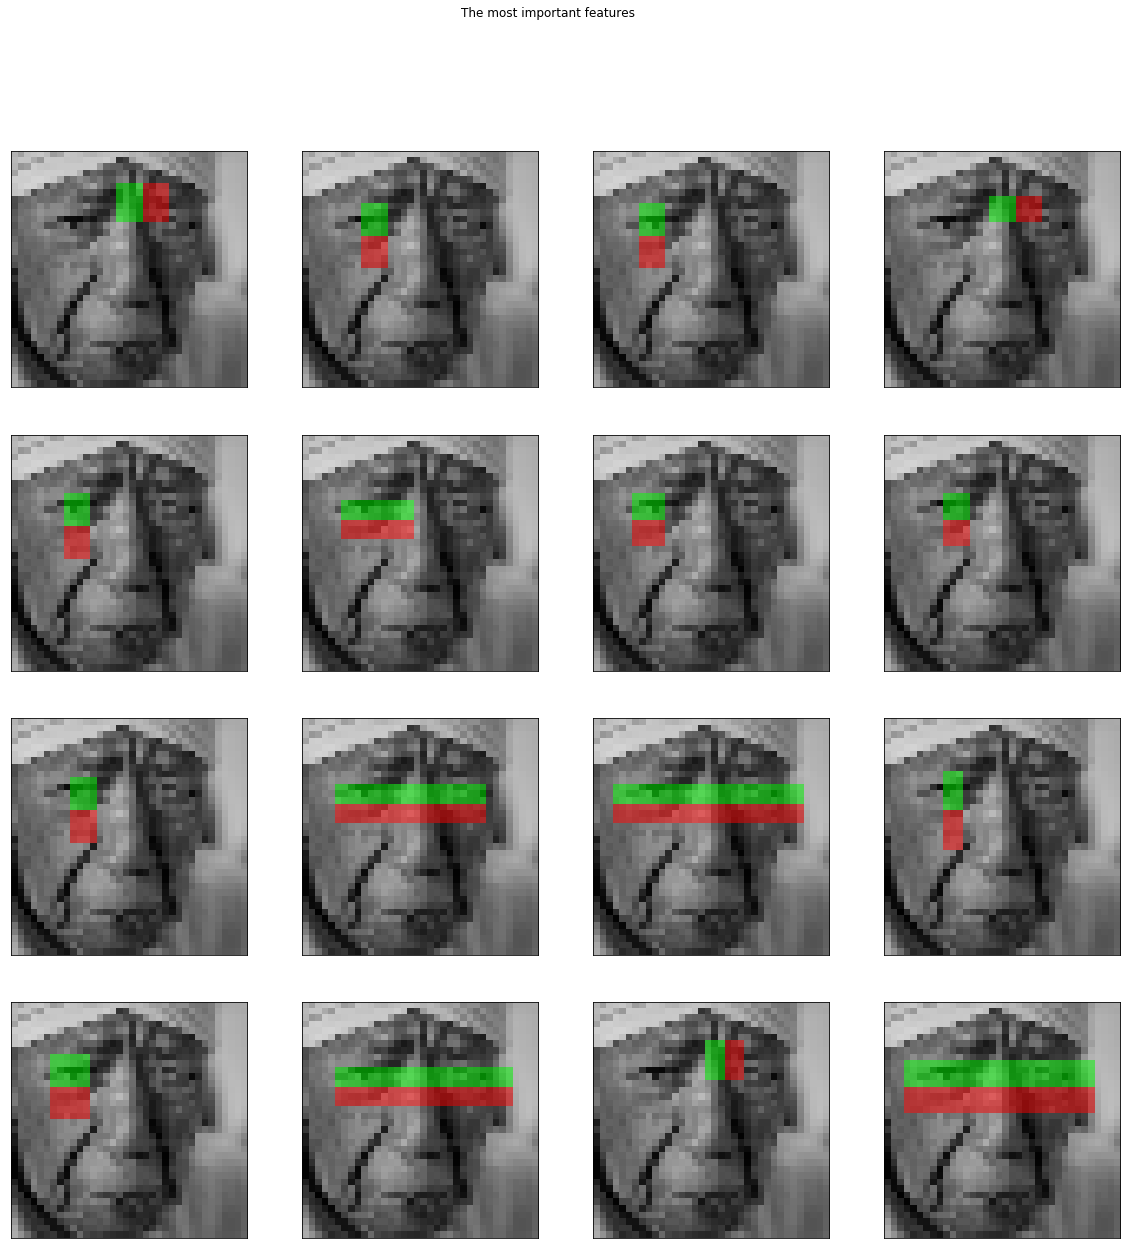

In [132]:
fig, axes = plt.subplots(4,4, figsize=(20,20))
for idx, ax in enumerate(axes.ravel()):
    image = cv2.resize(images_t[0], (36,36))
    image = draw_haar_like_feature(image, 0, 0, 36, 36,
                                   [feature_coord[idx_sorted[idx]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle('The most important features')

Text(0.5, 0.98, 'The most important features')

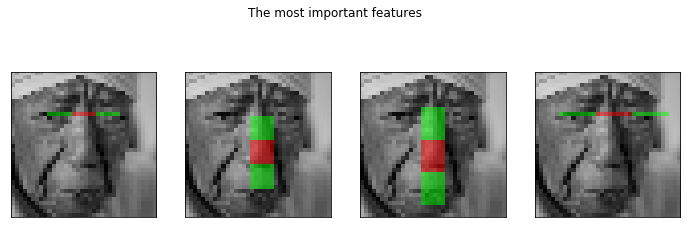

In [142]:
fig, axes = plt.subplots(1,4, figsize=(12,4))
idxs = [1250,1325,1341,1403,1448]
for idx, ax in enumerate(axes.ravel()):
    image = cv2.resize(images_t[0], (36,36))
    image = draw_haar_like_feature(image, 0, 0, 36, 36,
                                   [feature_coord[idx_sorted[idxs[idx]]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle('The most important features')

In [143]:
cdf_feature_importances = np.cumsum(clf.feature_importances_[idx_sorted])
cdf_feature_importances /= np.max(cdf_feature_importances)
sig_feature_count = np.count_nonzero(cdf_feature_importances < 0.7)
sig_feature_percent = round(sig_feature_count /
                            len(cdf_feature_importances) * 100, 1)
print(('{} features, or {}%, account for 70% of branch points in the '
       'random forest.').format(sig_feature_count, sig_feature_percent))

967 features, or 0.1%, account for 70% of branch points in the random forest.


In [48]:
ys = [i/200 for i in range(0,200)]
xs = []
for i in range(len(ys)):
    sig_feature_count = np.count_nonzero(cdf_feature_importances < ys[i])
    xs.append(sig_feature_count)

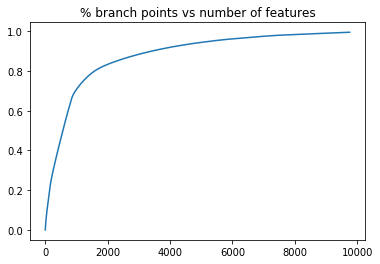

In [51]:
plt.plot(xs, ys)
plt.title("% branch points vs number of features")
plt.show()

In [56]:
np.count_nonzero(cdf_feature_importances < .82)

1807

In [57]:
n_features = 1800

In [58]:
feature_coord_sel = feature_coord[idx_sorted[:n_features]]
feature_type_sel = feature_type[idx_sorted[:n_features]]

In [59]:
n_features2 = 900

In [60]:
feature_coord_sel2 = feature_coord[idx_sorted[:n_features2]]
feature_type_sel2 = feature_type[idx_sorted[:n_features2]]

In [151]:
Xt_900 = getx2(test_face_names, 300, nonfaces_t, feature_type_sel2, feature_coord_sel2)

# Getting data

In [62]:
face_filenames0 = sorted(glob(os.path.join('data/train_0', '*.jpg')))
num_face_filenames0 = len(face_filenames0)
num_face_filenames0

4020

In [63]:
face_filenames25 = sorted(glob(os.path.join('data/train_25', '*.jpg')))
num_face_filenames25 = len(face_filenames25)
num_face_filenames25

4020

In [64]:
face_filenames50 = sorted(glob(os.path.join('data/train_50', '*.jpg')))
num_face_filenames50 = len(face_filenames50)
num_face_filenames50

4020

In [65]:
face_filenames75 = sorted(glob(os.path.join('data/train_75', '*.jpg')))
num_face_filenames75 = len(face_filenames75)
num_face_filenames75

4020

In [66]:
face_filenames100 = sorted(glob(os.path.join('data/train_100', '*.jpg')))
num_face_filenames100 = len(face_filenames100)
num_face_filenames100

4020

In [33]:
count = 0
for f in face_filenames0:
    if int(f.split('_')[3]) is 0: # race is white
        count += 1
count

4020

In [67]:
nonface_filenames = sorted(glob(os.path.join('data/training_nonfaces', '*.jpg')))
num_nonface_filenames = len(nonface_filenames)
num_nonface_filenames

250

# Classification

In [154]:
def getacc(predicted, actual):
    preds = []
    for p in predicted:
        if p >= 0.5:
            preds.append(1)
        else:
            preds.append(0)
    return 1 - sum(abs(preds-actual))/len(preds)

In [205]:
def getscore(X, y, params):
    predicted = logistic_prob(X, params)
    return getacc(predicted, y)

In [69]:
n = 4020

In [317]:
nonfaces = []
for i in range(n):
    # Read a random nonface file
    j = random.randint(0, len(nonface_filenames) - 1)
    nonface = cv2.imread(nonface_filenames[j], cv2.IMREAD_GRAYSCALE)
    wsize = random.randint(36, min(nonface.shape[0], nonface.shape[1]))
    row = random.randint(0, nonface.shape[0]-wsize)
    col = random.randint(0, nonface.shape[1]-wsize)
    crop = nonface[row:row+wsize, col:col+wsize]

    # Resize to be the right size
    crop = cv2.resize(crop, (200, 200))
    nonfaces.append(crop)

In [80]:
t_start = time()
X0 = getx2(face_filenames0, n, feature_type_sel2, feature_coord_sel2)
time() - t_start

13.786381959915161

In [82]:
X0.shape

(8040, 900)

In [84]:
y = np.array([1]*n + [0]*n)

In [308]:
X0 = getx2(face_filenames0, n, nonfaces, feature_type_sel2, feature_coord_sel2)
X25 = getx2(face_filenames25, n, nonfaces, feature_type_sel2, feature_coord_sel2)
X50 = getx2(face_filenames50, n, nonfaces, feature_type_sel2, feature_coord_sel2)
X75 = getx2(face_filenames75, n, nonfaces, feature_type_sel2, feature_coord_sel2)
X100 = getx2(face_filenames100, n, nonfaces, feature_type_sel2, feature_coord_sel2)
Xt = getx2(face_filenames0, 300, nonfaces_t, feature_type_sel2, feature_coord_sel2)


### 0%

In [418]:
t_start = time()
params = logistic_fit(X0, y, 0.005)
predicted = logistic_prob(Xt_900, params)
print(time() - t_start)
print(getacc(predicted, y_t))

65.20721292495728
0.9783333333333333


In [191]:
t_start = time()
rf0 = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf0.fit(X0, y)
print(time() - t_start)
print(rf0.score(Xt_900, y_t))

51.504207134246826
0.9733333333333334


In [330]:
t_start = time()
rf0_ = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf0_.fit(X0, y)
print(time() - t_start)
print(rf0_.score(Xt_900, y_t))

28.579165935516357
0.9866666666666667


### 25%

In [419]:
t_start = time()
params25 = logistic_fit(X25, y, 0.005)
predicted25 = logistic_prob(Xt_900, params25)
print(time() - t_start)
print(getacc(predicted25, y_t))

65.45319414138794
0.9883333333333333


In [193]:
t_start = time()
rf25 = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf25.fit(X25, y)
print(time() - t_start)
print(rf25.score(Xt_900, y_t))

54.29618191719055
0.9816666666666667


In [329]:
t_start = time()
rf25_ = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf25_.fit(X25, y)
print(time() - t_start)
print(rf25_.score(Xt_900, y_t))

34.24504089355469
0.9966666666666667


### 50%

In [420]:
t_start = time()
params50 = logistic_fit(X50, y, 0.005)
predicted50 = logistic_prob(Xt_900, params50)
print(time() - t_start)
print(getacc(predicted50, y_t))

66.63791012763977
0.9783333333333333


In [195]:
t_start = time()
rf50 = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf50.fit(X50, y)
print(time() - t_start)
print(rf50.score(Xt_900, y_t))

63.43332099914551
0.99


In [328]:
t_start = time()
rf50_ = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf50_.fit(X50, y)
print(time() - t_start)
print(rf50_.score(Xt_900, y_t))

37.5260112285614
0.9966666666666667


### 75%

In [421]:
t_start = time()
params75 = logistic_fit(X75, y, 0.005)
predicted75 = logistic_prob(Xt_900, params75)
print(time() - t_start)
print(getacc(predicted75, y_t))

60.54207682609558
0.985


In [197]:
t_start = time()
rf75 = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf75.fit(X75, y)
print(time() - t_start)
print(rf75.score(Xt_900, y_t))

63.48205590248108
0.9833333333333333


In [327]:
t_start = time()
rf75_ = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf75_.fit(X75, y)
print(time() - t_start)
print(rf75_.score(Xt_900, y_t))

35.21123290061951
0.9983333333333333


### 100%

In [422]:
t_start = time()
params100 = logistic_fit(X100, y, 0.005)
predicted100 = logistic_prob(Xt_900, params100)
print(time() - t_start)
print(getacc(predicted100, y_t))

61.95895195007324
0.9833333333333333


In [199]:
t_start = time()
rf100 = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf100.fit(X100, y)
print(time() - t_start)
print(rf100.score(Xt_900, y_t))

63.2666540145874
0.9816666666666667


In [326]:
t_start = time()
rf100_ = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf100_.fit(X100, y)
print(time() - t_start)
print(rf100_.score(Xt_900, y_t))

36.13964295387268
0.9966666666666667


### Scores, separated by race

In [325]:
# use b_inds and w_inds to select rows of X_t and y_t
Xb_t = Xt_900[b_inds]
yb_t = y_t[b_inds]
Xw_t = Xt_900[w_inds]
yw_t = y_t[w_inds]
Xb_t.shape, Xb_t_1800.shape, yb_t.shape, Xw_t.shape, Xw_t_1800.shape, yw_t.shape

((150, 900), (150, 1800), (150,), (150, 900), (150, 1800), (150,))

In [240]:
np.savetxt("b_inds.csv", np.array(b_inds), delimiter=",")

In [237]:
np.savetxt("w_inds.csv", w_inds, delimiter=",")

In [209]:
def rfscores(rfs, Xt, Xbt, Xwt):
    os = []
    bs = []
    ws = []
    for i in range(len(rfs)):
        print(i*25)
        o = rfs[i].score(Xt, y_t)
        b = rfs[i].score(Xbt, yb_t)
        w = rfs[i].score(Xwt, yw_t)
        print("overall:", o)
        print("black:", b)
        print("white:", w)
        os.append(o)
        bs.append(b)
        ws.append(w)
    return os, bs, ws

In [210]:
def logscores(logs, Xt, Xbt, Xwt):
    os = []
    bs = []
    ws = []
    for i in range(len(logs)):
        print(i*25)
        o = getscore(Xt, y_t, logs[i])
        b = getscore(Xbt, yb_t, logs[i])
        w = getscore(Xwt, yw_t, logs[i])
        print("overall:", o)
        print("black:", b)
        print("white:", w)
        os.append(o)
        bs.append(b)
        ws.append(w)
    return os, bs, ws

In [423]:
os_l, bs_l, ws_l = logscores([params, params25, params50, params75, params100], Xt_900, Xb_t, Xw_t)

0
overall: 0.9783333333333333
black: 0.94
white: 0.9733333333333334
25
overall: 0.9883333333333333
black: 0.96
white: 0.9933333333333333
50
overall: 0.9783333333333333
black: 0.96
white: 0.98
75
overall: 0.985
black: 0.9533333333333334
white: 0.9933333333333333
100
overall: 0.9833333333333333
black: 0.96
white: 0.98


In [213]:
os_r, bs_r, ws_r = rfscores([rf0, rf25, rf50, rf75, rf100], Xt_900, Xb_t, Xw_t)

0
overall: 0.9733333333333334
black: 0.9
white: 0.9933333333333333
25
overall: 0.9816666666666667
black: 0.9466666666666667
white: 0.9866666666666667
50
overall: 0.99
black: 0.9666666666666667
white: 0.9933333333333333
75
overall: 0.9833333333333333
black: 0.9733333333333334
white: 0.9933333333333333
100
overall: 0.9816666666666667
black: 0.9733333333333334
white: 0.9933333333333333


In [331]:
os_r_, bs_r_, ws_r_ = rfscores([rf0_, rf25_, rf50_, rf75_, rf100_], Xt_900, Xb_t, Xw_t)

0
overall: 0.9866666666666667
black: 0.9466666666666667
white: 1.0
25
overall: 0.9966666666666667
black: 0.9866666666666667
white: 1.0
50
overall: 0.9966666666666667
black: 0.9866666666666667
white: 1.0
75
overall: 0.9983333333333333
black: 0.9933333333333333
white: 1.0
100
overall: 0.9966666666666667
black: 0.9933333333333333
white: 0.9933333333333333


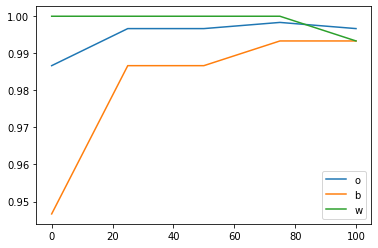

In [332]:
plt.plot([0, 25, 50, 75, 100], os_r_, label="o")
plt.plot([0, 25, 50, 75, 100], bs_r_, label="b")
plt.plot([0, 25, 50, 75, 100], ws_r_, label="w")
plt.legend()

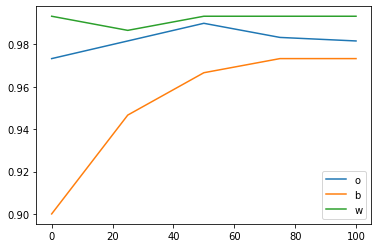

In [218]:
plt.plot([0, 25, 50, 75, 100], os_r, label="o")
plt.plot([0, 25, 50, 75, 100], bs_r, label="b")
plt.plot([0, 25, 50, 75, 100], ws_r, label="w")
plt.legend()

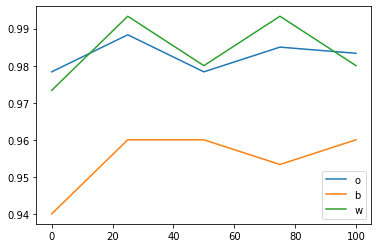

In [424]:
plt.plot([0, 25, 50, 75, 100], os_l, label="o")
plt.plot([0, 25, 50, 75, 100], bs_l, label="b")
plt.plot([0, 25, 50, 75, 100], ws_l, label="w")
plt.legend()

## Visualize Top Features

In [257]:
# Extract all possible features
feature_coord, feature_type = feature_coord_sel2, feature_type_sel2

In [354]:
def gettop(fnames, rf):
    im = cv2.resize(cv2.imread(fnames[5], cv2.IMREAD_GRAYSCALE),(36,36))
    fig, axes = plt.subplots(3,4, figsize=(16,8))
    # Sort features in order of importance and plot the six most significant
    idx_sorted = np.argsort(rf.feature_importances_)[::-1]
    for idx, ax in enumerate(axes.ravel()):
        image = draw_haar_like_feature(im, 0, 0, 36, 36,
                                       [feature_coord_sel[idx_sorted[idx]]])
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])

    fig.suptitle('The most important features')

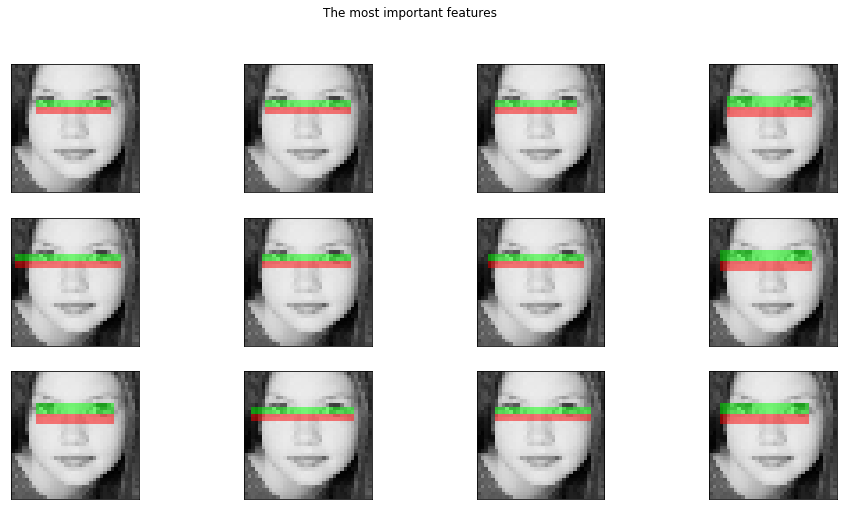

In [355]:
gettop(face_filenames0, rf0_)

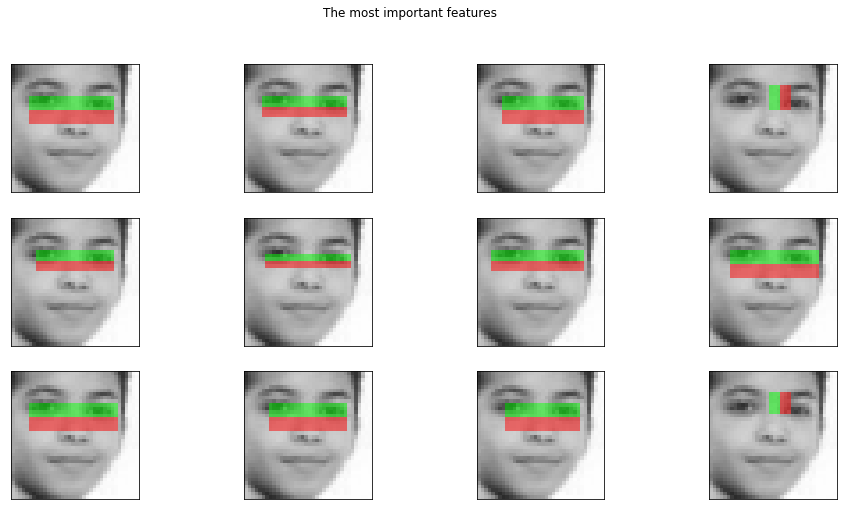

In [356]:
gettop(face_filenames25, rf25_)

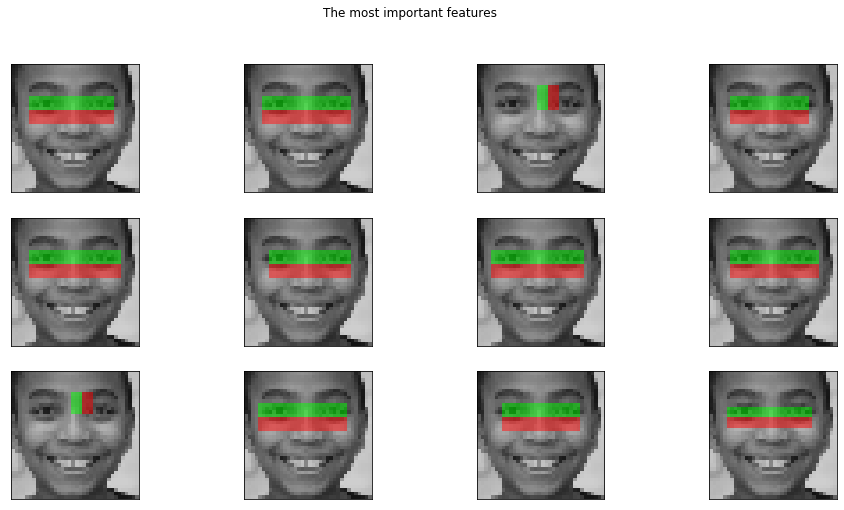

In [357]:
gettop(face_filenames50, rf50_)

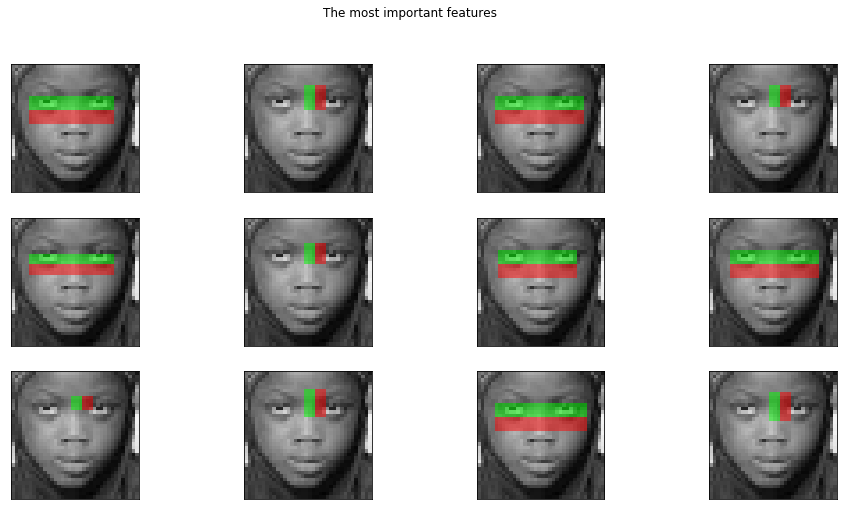

In [358]:
gettop(face_filenames75, rf75_)

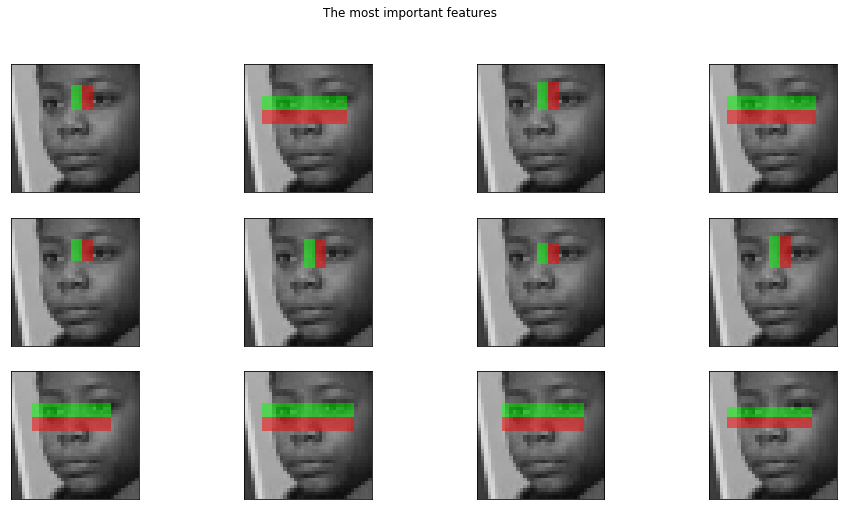

In [347]:
gettop(face_filenames100, rf100_)

# Comparing skin tone of images

In [367]:
np.array(faces_t)[b_inds].shape

(150, 200, 200)

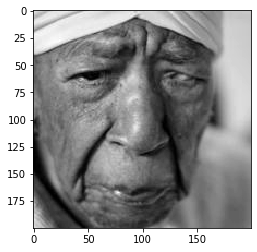

In [453]:
plt.imshow(np.array(faces_t)[b_inds[0]], cmap='gray')

In [380]:
img = np.array(faces_t)[b_inds[0]]

In [390]:
hsv = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), cv2.COLOR_BGR2HSV)
_, _, v = cv2.split(hsv)
np.median(v)

102.0

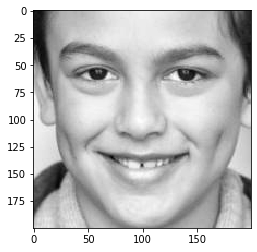

In [452]:
plt.imshow(np.array(faces_t)[w_inds[0]], cmap='gray')

In [473]:
img = np.array(faces_t)[w_inds[0]]

In [515]:
hsv = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), cv2.COLOR_BGR2HSV)
_, _, v = cv2.split(hsv)
np.median(v)

173.0

In [516]:
hsv = hsv.astype(np.int32)

In [517]:
hsv[:,:,2]

array([[ 35,  35,  36, ...,  61,  56,  51],
       [ 34,  38,  41, ...,  60,  55,  50],
       [ 35,  41,  46, ...,  59,  55,  50],
       ...,
       [169, 182, 186, ..., 178, 179, 178],
       [172, 185, 190, ..., 185, 185, 185],
       [172, 184, 190, ..., 191, 191, 190]], dtype=int32)

In [508]:
np.mean(hsv[:,:,2]), np.std(hsv[:,:,2])

(163.365525, 39.53961831472801)

In [518]:
hsv[:,:,2] = 125+47.5*(hsv[:,:,2]-np.mean(hsv[:,:,2]))/np.std(hsv[:,:,2])

In [514]:
125+47.5*(35-163)/40

-27.0

In [519]:
hsv[:,:,2]

array([[-29, -29, -28, ...,   2,  -3,  -9],
       [-30, -25, -22, ...,   0,  -5, -11],
       [-29, -22, -15, ...,   0,  -5, -11],
       ...,
       [131, 147, 152, ..., 142, 143, 142],
       [135, 150, 156, ..., 150, 150, 150],
       [135, 149, 156, ..., 158, 158, 156]], dtype=int32)

In [538]:
hsv[hsv>254] = 254

In [523]:
hsv[hsv<0] = 0

In [524]:
hsv[:,:,2]

array([[  0,   0,   0, ...,   2,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [131, 147, 152, ..., 142, 143, 142],
       [135, 150, 156, ..., 150, 150, 150],
       [135, 149, 156, ..., 158, 158, 156]], dtype=int32)

In [527]:
np.mean(hsv[:,:,2])

124.953625

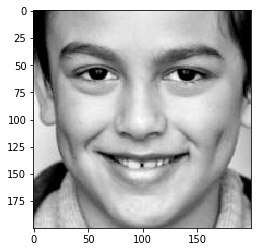

In [613]:
plt.imshow(hsv[:,:,2], cmap='gray')

In [658]:
def normalize(img):
    img = img.astype(np.int32)
#     print(np.mean(img))
    m, s = np.mean(img), np.std(img)
    img = 125+47*(img-m)/s
    img[img>255] = 255
    img[img<0] = 0
#     print(np.mean(img))
    return img

152.920125
125.0


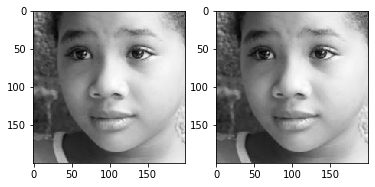

In [652]:
plt.subplot(1,2,1)
plt.imshow(np.array(faces_t)[b_inds[2]], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(normalize(np.array(faces_t)[b_inds[2]]), cmap='gray')

163.365525
125.40513080163775


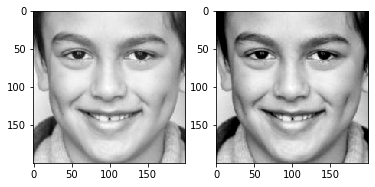

In [653]:
plt.subplot(1,2,1)
plt.imshow(np.array(faces_t)[w_inds[0]], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(normalize(np.array(faces_t)[w_inds[0]]), cmap='gray')

In [449]:
# average black face image brightness/intensity:
vs_b = []
vs_b2 = []
stds_b = []
for b in b_inds:
    img = np.array(faces_t)[b]
    hsv = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), cv2.COLOR_BGR2HSV)
    _, _, v = cv2.split(hsv)
    vs_b.append(np.mean(v))
    vs_b2.append(np.median(v))
    stds_b.append(np.std(v))

In [450]:
np.mean(vs_b), np.median(vs_b2), np.mean(stds_b), np.median(stds_b)

(109.63445466666667, 105.5, 48.84662617726078, 47.37796866193072)

(array([ 4.,  3.,  9., 24., 25., 21., 25., 19., 16.,  4.]),
 array([ 41.9701 ,  54.29725,  66.6244 ,  78.95155,  91.2787 , 103.60585,
        115.933  , 128.26015, 140.5873 , 152.91445, 165.2416 ]),
 <a list of 10 Patch objects>)

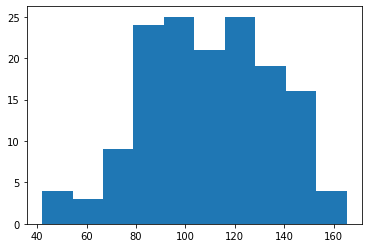

In [443]:
plt.hist(vs_b)

(array([ 3.,  9., 36., 40., 31., 16.,  8.,  5.,  1.,  1.]),
 array([22.81833815, 29.53079923, 36.24326031, 42.95572139, 49.66818247,
        56.38064354, 63.09310462, 69.8055657 , 76.51802678, 83.23048786,
        89.94294894]),
 <a list of 10 Patch objects>)

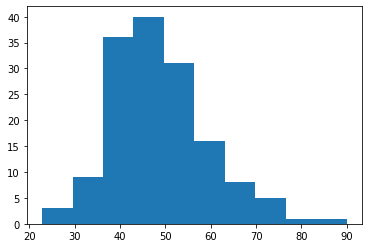

In [451]:
plt.hist(stds_b)

In [444]:
# average white face image brightness/intensity:
vs_w = []
vs_w2 = []
stds_w = []
for w in w_inds:
    img = np.array(faces_t)[w]
    hsv = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), cv2.COLOR_BGR2HSV)
    _, _, v = cv2.split(hsv)
    vs_w.append(np.mean(v))
    vs_w2.append(np.median(v))
    stds_w.append(np.std(v))

In [445]:
np.mean(vs_w), np.median(vs_w2), np.mean(stds_w), np.median(stds_w)

(137.76237866666668, 147.0, 46.904933581518925, 47.001169565557745)

(array([ 1.,  4.,  3., 18., 22., 35., 30., 24.,  7.,  6.]),
 array([ 60.659425 ,  74.1564575,  87.65349  , 101.1505225, 114.647555 ,
        128.1445875, 141.64162  , 155.1386525, 168.635685 , 182.1327175,
        195.62975  ]),
 <a list of 10 Patch objects>)

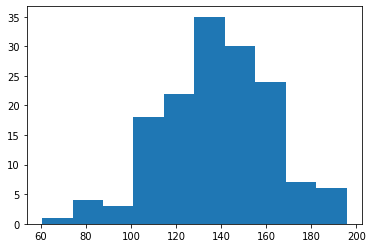

In [442]:
plt.hist(vs_w)

(array([ 9., 20., 25., 21., 27., 26., 11.,  4.,  4.,  3.]),
 array([22.80591848, 28.84964981, 34.89338114, 40.93711247, 46.9808438 ,
        53.02457513, 59.06830646, 65.11203779, 71.15576911, 77.19950044,
        83.24323177]),
 <a list of 10 Patch objects>)

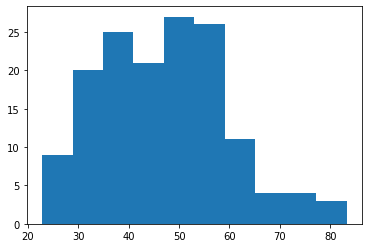

In [654]:
plt.hist(stds_w)

# Training on normalized images

In [819]:
def regenerate_nonfaces():
    nonfaces = []
    for i in range(n):
        # Read a random nonface file
        j = random.randint(0, len(nonface_filenames) - 1)
        nonface = cv2.imread(nonface_filenames[j], cv2.IMREAD_GRAYSCALE)
        wsize = random.randint(36, min(nonface.shape[0], nonface.shape[1]))
        row = random.randint(0, nonface.shape[0]-wsize)
        col = random.randint(0, nonface.shape[1]-wsize)
        crop = nonface[row:row+wsize, col:col+wsize]

        # Resize to be the right size
        crop = cv2.resize(crop, (200, 200))
        nonfaces.append(crop)
    nonfaces_t = []
    for i in range(n_test):
        # Read a random nonface file
        j = random.randint(0, n_nonfaces_test - 1)
        nonface = cv2.imread(test_nonface_names[j], cv2.IMREAD_GRAYSCALE)

        wsize = random.randint(36, min(nonface.shape[0], nonface.shape[1]))
        row = random.randint(0, nonface.shape[0]-wsize)
        col = random.randint(0, nonface.shape[1]-wsize)
        crop = nonface[row:row+wsize, col:col+wsize]

        # Resize to be the right size
        crop = cv2.resize(crop, (200, 200))
        nonfaces_t.append(crop)
    return nonfaces, nonfaces_t

In [870]:
def pipeline(f, times):
    def getx3(facefiles, n, nonfaces, feature_types, feature_coords):
        ims = [f(i) for i in getimgs(facefiles, nonfaces, n)]
        X = delayed(extract_feature_image(img, feature_types, feature_coords) for img in ims)
        return np.array(X.compute(scheduler='threads'))
    
    t_start = time()
    
    os_rs = []
    bs_rs = []
    ws_rs = []
    for i in range(times):
        nonfaces, nonfaces_t = regenerate_nonfaces()
        
        X0 = getx3(face_filenames0, n, nonfaces, feature_type_sel2, feature_coord_sel2)
        print(X0.shape)
        X25 = getx3(face_filenames25, n, nonfaces, feature_type_sel2, feature_coord_sel2)
        print(X25.shape)
        X50 = getx3(face_filenames50, n, nonfaces, feature_type_sel2, feature_coord_sel2)
        print(X50.shape)
        X75 = getx3(face_filenames75, n, nonfaces, feature_type_sel2, feature_coord_sel2)
        print(X75.shape)
        X100 = getx3(face_filenames100, n, nonfaces, feature_type_sel2, feature_coord_sel2)
        print(X100.shape)
        Xt = getx3(test_face_names, 300, nonfaces_t, feature_type_sel2, feature_coord_sel2)
        print(Xt.shape)
        
        rf0 = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
        rf0.fit(X0, y)
        print(rf0.score(Xt_900, y_t))
        rf25 = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
        rf25.fit(X25, y)
        print(rf25.score(Xt_900, y_t))
        rf50 = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
        rf50.fit(X50, y)
        print(rf50.score(Xt_900, y_t))
        rf75 = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
        rf75.fit(X75, y)
        print(rf75.score(Xt_900, y_t))
        rf100 = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
        rf100.fit(X100, y)
        print(rf100.score(Xt_900, y_t))

        os_r, bs_r, ws_r = rfscores([rf0, rf25, rf50, rf75, rf100], Xt_900, Xb_t, Xw_t)
        os_rs.append(os_r)
        bs_rs.append(bs_r)
        ws_rs.append(ws_r)
    
    plt.plot([0, 25, 50, 75, 100], os_r, label="o")
    plt.plot([0, 25, 50, 75, 100], bs_r, label="b")
    plt.plot([0, 25, 50, 75, 100], ws_r, label="w")
    plt.legend()
    plt.show()
    
    print(time()-t_start)
    return os_rs, bs_rs, ws_rs
    

(8040, 900)
(8040, 900)
(8040, 900)
(8040, 900)
(8040, 900)
(600, 900)
0.97
0.9833333333333333
0.9866666666666667
0.99
0.985
0
overall: 0.97
black: 0.9
white: 0.9866666666666667
25
overall: 0.9833333333333333
black: 0.9466666666666667
white: 0.9933333333333333
50
overall: 0.9866666666666667
black: 0.96
white: 0.9933333333333333
75
overall: 0.99
black: 0.9733333333333334
white: 0.9933333333333333
100
overall: 0.985
black: 0.98
white: 0.9933333333333333
(8040, 900)
(8040, 900)
(8040, 900)
(8040, 900)
(8040, 900)
(600, 900)
0.97
0.9816666666666667
0.9883333333333333
0.99
0.9816666666666667
0
overall: 0.97
black: 0.9
white: 0.9866666666666667
25
overall: 0.9816666666666667
black: 0.9466666666666667
white: 0.9866666666666667
50
overall: 0.9883333333333333
black: 0.9666666666666667
white: 0.9933333333333333
75
overall: 0.99
black: 0.9733333333333334
white: 0.9933333333333333
100
overall: 0.9816666666666667
black: 0.9733333333333334
white: 0.9933333333333333
(8040, 900)
(8040, 900)
(8040, 900

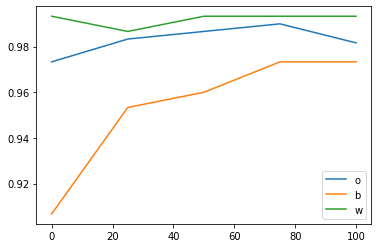

4004.305821418762


In [871]:
os_rs, bs_rs, ws_rs = pipeline(lambda x: x, 10)

In [872]:
def plots(os_rs, bs_rs, ws_rs):
    plt.plot([0,25,50,75,100],np.mean(np.array(os_rs),axis=0),label='o')
    plt.plot([0,25,50,75,100],np.mean(np.array(bs_rs),axis=0),label='b')
    plt.plot([0,25,50,75,100],np.mean(np.array(ws_rs),axis=0),label='w')
    plt.plot([0,25,50,75,100], np.array(np.mean(np.array(os_rs),axis=0)+np.std(np.array(os_rs),axis=0)),':',label='o+')
    plt.plot([0,25,50,75,100], np.array(np.mean(np.array(os_rs),axis=0)-np.std(np.array(os_rs),axis=0)),':',label='o-')
    plt.plot([0,25,50,75,100], np.array(np.mean(np.array(bs_rs),axis=0)+np.std(np.array(bs_rs),axis=0)),':',label='o+')
    plt.plot([0,25,50,75,100], np.array(np.mean(np.array(bs_rs),axis=0)-np.std(np.array(bs_rs),axis=0)),':',label='o-')
    plt.plot([0,25,50,75,100], np.array(np.mean(np.array(ws_rs),axis=0)+np.std(np.array(ws_rs),axis=0)),':',label='o+')
    plt.plot([0,25,50,75,100], np.array(np.mean(np.array(ws_rs),axis=0)-np.std(np.array(ws_rs),axis=0)),':',label='o-')
    plt.legend()
    plt.show()

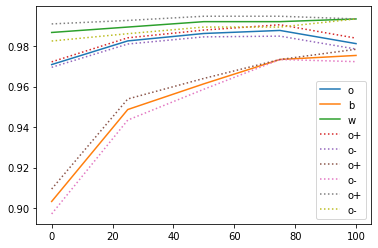

In [873]:
plots(os_rs, bs_rs, ws_rs)

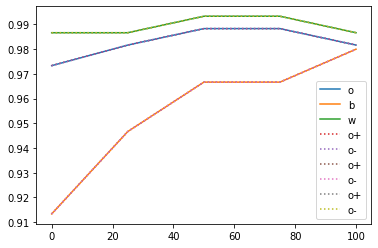

In [817]:
plots(os_rsn, bs_rsn, ws_rsn)

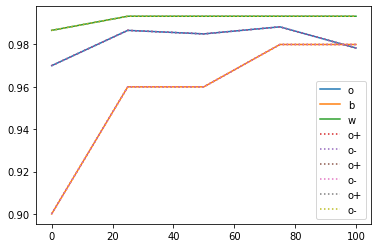

In [818]:
plots(os_rss, bs_rss, ws_rss)

In [805]:
np.array(np.mean(np.array(os_rs),axis=0)+np.std(np.array(os_rs),axis=0)+1)

array([1.975     , 1.98166667, 1.98666667, 1.985     , 1.98166667])

In [ ]:
np.mean(np.array(os_rs),axis=0)+np.std(np.array(os_rs),axis=0)

(8040, 900)
(8040, 900)
(8040, 900)
(8040, 900)
(8040, 900)
(600, 900)
0.9733333333333334
0.9816666666666667
0.9883333333333333
0.9883333333333333
0.9816666666666667
0
overall: 0.9733333333333334
black: 0.9133333333333333
white: 0.9866666666666667
25
overall: 0.9816666666666667
black: 0.9466666666666667
white: 0.9866666666666667
50
overall: 0.9883333333333333
black: 0.9666666666666667
white: 0.9933333333333333
75
overall: 0.9883333333333333
black: 0.9666666666666667
white: 0.9933333333333333
100
overall: 0.9816666666666667
black: 0.98
white: 0.9866666666666667


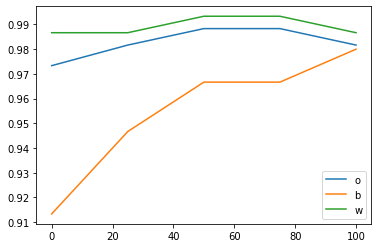

486.97529673576355


In [664]:
pipeline(normalize)

In [666]:
sharpen_kernel = np.array([0, -1, 0, -1, 5, -1, 0, -1, 0])

In [ ]:
im = np.array(faces_t)[b_inds[0]]

In [ ]:
plt.imshow(gradient_strength(im), cmap='gray')

In [ ]:
plt.imshow(gradient_orientation(im), cmap='gray')

In [674]:
im_sharp = cv2.filter2D(src=im, ddepth=-1, kernel=sharpen_kernel)

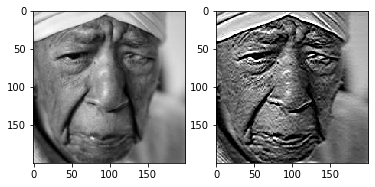

In [876]:
plt.subplot(1,2,1)
plt.imshow(np.array(faces_t)[b_inds[0]], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(sharpen(np.array(faces_t)[b_inds[0]]), cmap='gray')

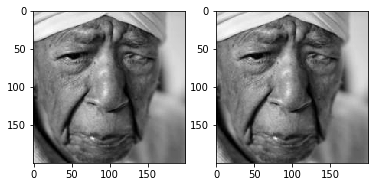

In [877]:
plt.subplot(1,2,1)
plt.imshow(np.array(faces_t)[b_inds[0]], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(normalize(np.array(faces_t)[b_inds[0]]), cmap='gray')

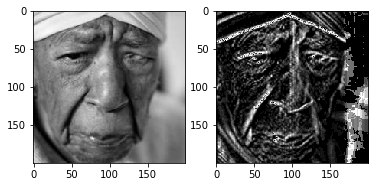

In [878]:
plt.subplot(1,2,1)
plt.imshow(np.array(faces_t)[b_inds[0]], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(gradient_strength(np.array(faces_t)[b_inds[0]]), cmap='gray')

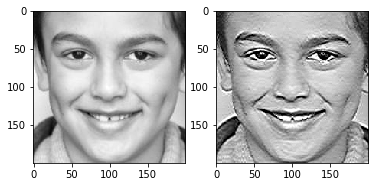

In [874]:
plt.subplot(1,2,1)
plt.imshow(np.array(faces_t)[w_inds[0]], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(sharpen(np.array(faces_t)[w_inds[0]]), cmap='gray')

In [676]:
def sharpen(im):
    return cv2.filter2D(src=im, ddepth=-1, kernel=sharpen_kernel)

(8040, 900)
(8040, 900)
(8040, 900)
(8040, 900)
(8040, 900)
(600, 900)
0.97
0.9866666666666667
0.985
0.9883333333333333
0.9783333333333334
0
overall: 0.97
black: 0.9
white: 0.9866666666666667
25
overall: 0.9866666666666667
black: 0.96
white: 0.9933333333333333
50
overall: 0.985
black: 0.96
white: 0.9933333333333333
75
overall: 0.9883333333333333
black: 0.98
white: 0.9933333333333333
100
overall: 0.9783333333333334
black: 0.98
white: 0.9933333333333333


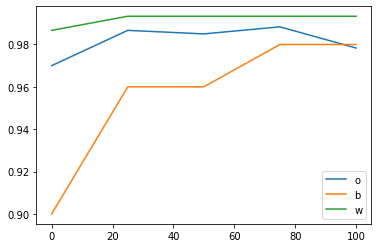

441.55330204963684


In [678]:
pipeline(sharpen)

In [679]:
def filteredGradient(im, sigma):
    def gprime(x,s):
        return (-1/(np.sqrt(2*np.pi)*s**3))*x*np.exp(-x**2/(2*s**2))

    # Gaussian of x, stdev s
    def g(x,s):
        return (1/(np.sqrt(2*np.pi)*s))*np.exp(-x**2/(2*s**2))

    # First derivative of Gaussian - kernel with halfwidth halfw, stdev s
    def gprimekernel(halfw,s):
        k = [gprime(x,s) for x in np.linspace(-halfw, halfw, 2*halfw)]
        return k

    # Gaussian - kernel with halfwidth halfw, stdev s
    def gkernel(halfw, s):
        k = [g(x,s) for x in np.linspace(-halfw, halfw, 2*halfw)]
        return k/np.sum(k)

    halfw = 3*sigma

    # create filters
    x = np.expand_dims(gprimekernel(halfw,sigma),0)
    xg = np.expand_dims(gkernel(halfw,sigma),0)
    y = np.expand_dims(gprimekernel(halfw,sigma),1)
    yg = np.expand_dims(gkernel(halfw,sigma),1)

    # convolve
    Fx = cv2.filter2D(im, -1, x)
    Fx = cv2.filter2D(Fx, -1, xg)
    Fy = cv2.filter2D(im, -1, y)
    Fy = cv2.filter2D(Fy, -1, yg)

    return Fx, Fy

In [687]:
from sklearn.preprocessing import MinMaxScaler

In [728]:
def transform(im):
    return MinMaxScaler((0,255)).fit_transform(im).astype(np.uint8)

In [729]:
def gradient_strength(im):
    Fx, Fy = filteredGradient(im, 1)
    return transform(np.array(np.sqrt(Fx**2 + Fy**2)))

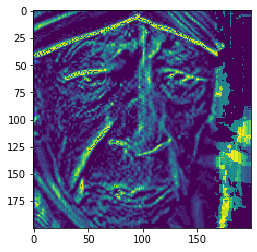

In [735]:
plt.subplot(1,2,1)
plt.imshow(np.array(faces_t)[w_inds[0]], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(normalize(np.array(faces_t)[w_inds[0]]), cmap='gray')
plt.imshow(gradient_strength(im))

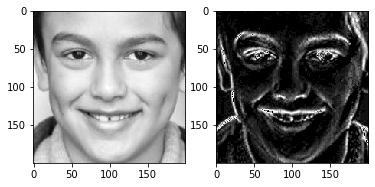

In [875]:
plt.subplot(1,2,1)
plt.imshow(np.array(faces_t)[w_inds[0]], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(gradient_strength(np.array(faces_t)[w_inds[0]]), cmap='gray')

(8040, 900)
(8040, 900)
(8040, 900)
(8040, 900)
(8040, 900)
(600, 900)
0.4866666666666667
0.485
0.4866666666666667
0.49
0.49333333333333335
0
overall: 0.4866666666666667
black: 0.0
white: 0.0
25
overall: 0.485
black: 0.0
white: 0.0
50
overall: 0.4866666666666667
black: 0.0
white: 0.0
75
overall: 0.49
black: 0.0
white: 0.0
100
overall: 0.49333333333333335
black: 0.0
white: 0.0


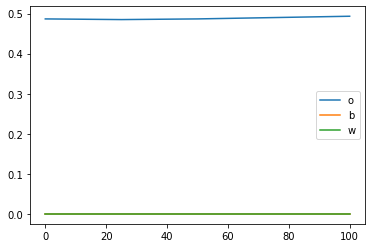

547.8333580493927


In [731]:
pipeline(gradient_strength)

# Predicting skin tone from Haar features

In [448]:
X50[:4020].shape

(4020, 900)

In [736]:
skintones = [int(face_filenames50[i].split('_')[3]) for i in range(n)]

In [737]:
rfskin = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rfskin.fit(X50[:4020], skintones)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [742]:
skintones_t = [int(test_face_names[i].split('_')[2]) for i in range(300)]

In [744]:
rfskin.score(Xt_900[:300], skintones_t)

0.82

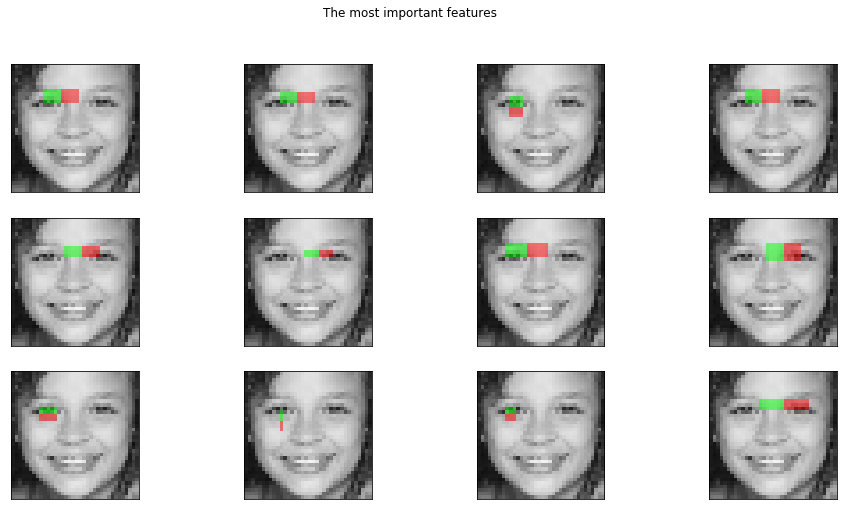

In [745]:
gettop(test_face_names, rfskin)

# False Positives, False Negatives

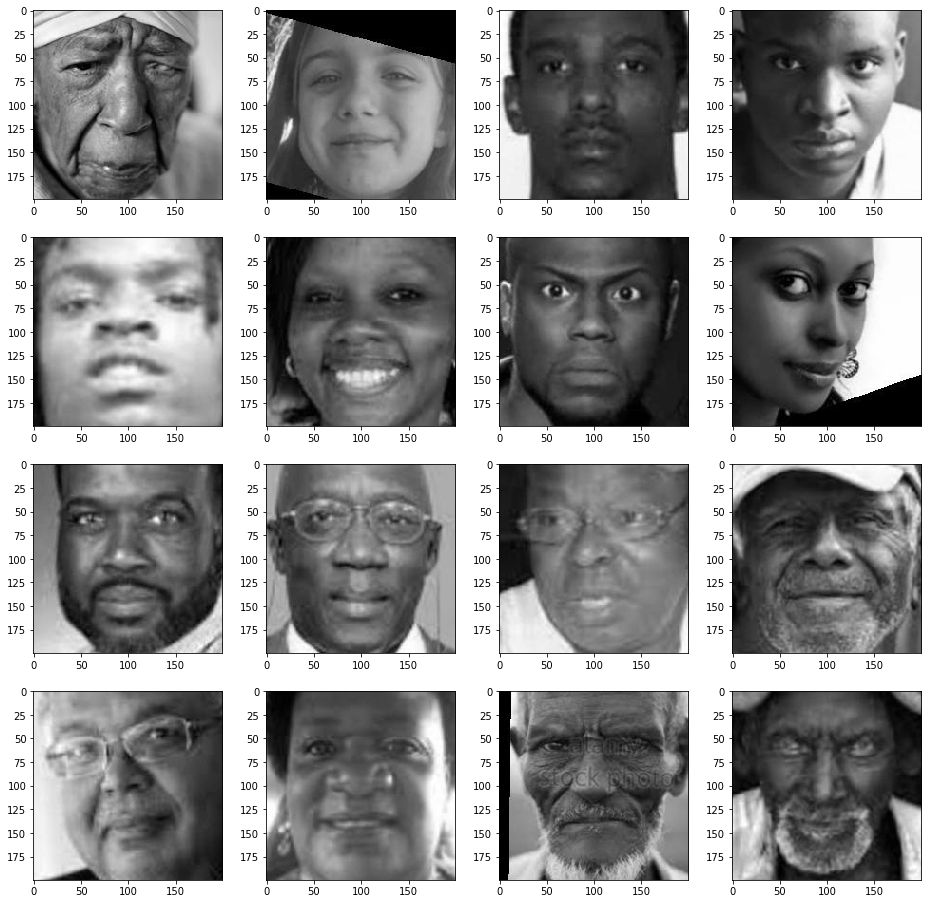

In [755]:
predictions0 = rf0.predict(Xt_900)
plt.subplots(4,4,figsize=(16,16))
count = 0
for i in range(300):
    if predictions0[i] != yt_900[i]:
        count += 1
        plt.subplot(4,4,count)
        plt.imshow(cv2.imread(test_face_names[i], cv2.IMREAD_GRAYSCALE), cmap='gray')
        

In [758]:
count = 0
for i in range(300,600):
    if predictions0[i] != yt_900[i]:
        count += 1
count

0

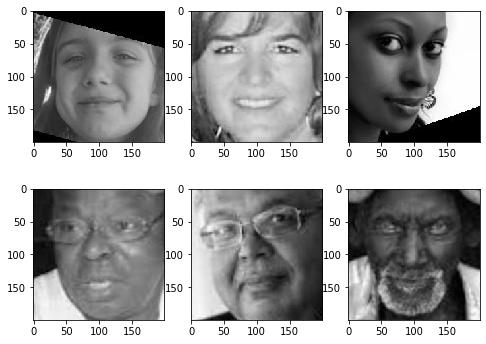

In [767]:
predictions50 = rf50.predict(Xt_900)
plt.subplots(2,3,figsize=(8,6))
count = 0
for i in range(300):
    if predictions50[i] != yt_900[i]:
        count += 1
        plt.subplot(2,3,count)
        plt.imshow(cv2.imread(test_face_names[i], cv2.IMREAD_GRAYSCALE), cmap='gray')
        

In [768]:
count = 0
for i in range(300,600):
    if predictions50[i] != yt_900[i]:
        count += 1
count

0

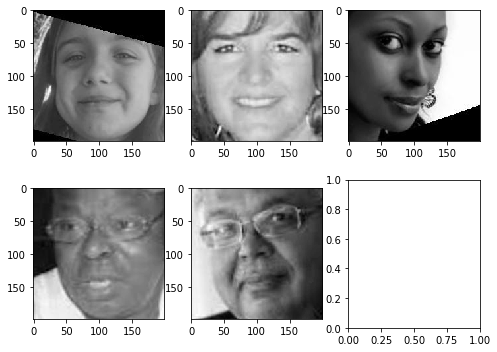

In [769]:
predictions100 = rf100.predict(Xt_900)
plt.subplots(2,3,figsize=(8,6))
count = 0
for i in range(300):
    if predictions100[i] != yt_900[i]:
        count += 1
        plt.subplot(2,3,count)
        plt.imshow(cv2.imread(test_face_names[i], cv2.IMREAD_GRAYSCALE), cmap='gray')
        

4

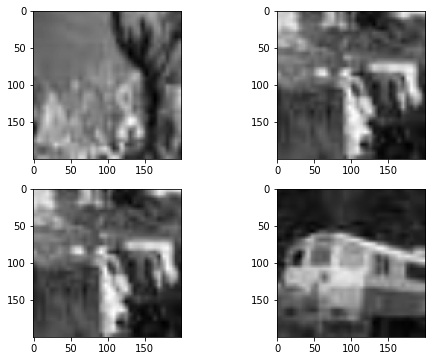

In [776]:
count = 0
plt.subplots(2,2,figsize=(8,6))
for i in range(300,600):
    if predictions100[i] != yt_900[i]:
        count += 1
        plt.subplot(2,2,count)
        plt.imshow(nonfaces_t[i-300], cmap='gray')
count

# Combine HOG and Haar features

In [833]:
# look at most important features as selected by randomforest

In [834]:
from hog36 import hog36

In [787]:
np.concatenate((np.array([[1,1],[2,2]]), np.array([[3],[3]])),axis=1)

array([[1, 1, 3],
       [2, 2, 3]])

In [838]:
hog0 = np.array([hog36(cv2.resize(im,(36,36)), 9, True) for im in getimgs(face_filenames0, nonfaces, n)])

In [839]:
hog0.shape

(8040, 900)

In [843]:
X0h = np.concatenate((X0, hog0),axis=1)

In [844]:
X0h.shape

(8040, 1800)

In [847]:
hog25 = np.array([hog36(cv2.resize(im,(36,36)), 9, True) for im in getimgs(face_filenames25, nonfaces, n)])
X25h = np.concatenate((X25, hog25),axis=1)

In [848]:
hog50 = np.array([hog36(cv2.resize(im,(36,36)), 9, True) for im in getimgs(face_filenames50, nonfaces, n)])
X50h = np.concatenate((X50, hog50),axis=1)

In [849]:
hog75 = np.array([hog36(cv2.resize(im,(36,36)), 9, True) for im in getimgs(face_filenames75, nonfaces, n)])
X75h = np.concatenate((X75, hog75),axis=1)

In [850]:
hog100 = np.array([hog36(cv2.resize(im,(36,36)), 9, True) for im in getimgs(face_filenames100, nonfaces, n)])
X100h = np.concatenate((X100, hog100),axis=1)

In [853]:
hogt = np.array([hog36(cv2.resize(im,(36,36)), 9, True) for im in getimgs(test_face_names, nonfaces_t, 300)])
Xt_900h = np.concatenate((Xt_900, hogt),axis=1)

In [855]:
rf0h = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf0h.fit(X0h, y)
print(rf0h.score(Xt_900h, y_t))
rf25h = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf25h.fit(X25h, y)
print(rf25h.score(Xt_900h, y_t))
rf50h = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf50h.fit(X50h, y)
print(rf50h.score(Xt_900h, y_t))
rf75h = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf75h.fit(X75h, y)
print(rf75h.score(Xt_900h, y_t))
rf100h = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
rf100h.fit(X100h, y)
print(rf100h.score(Xt_900h, y_t))

os_rh, bs_rh, ws_rh = rfscores([rf0h, rf25h, rf50h, rf75h, rf100h], Xt_900h, Xt_900h[b_inds], Xt_900h[w_inds])

0.9866666666666667
0.9933333333333333
0.995
0.9983333333333333
0.9966666666666667
0
overall: 0.9866666666666667
black: 0.9466666666666667
white: 1.0
25
overall: 0.9933333333333333
black: 0.9733333333333334
white: 1.0
50
overall: 0.995
black: 0.98
white: 1.0
75
overall: 0.9983333333333333
black: 0.9933333333333333
white: 1.0
100
overall: 0.9966666666666667
black: 0.9933333333333333
white: 0.9933333333333333


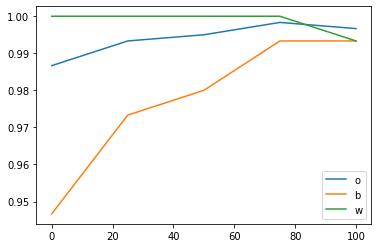

In [856]:
plt.plot([0, 25, 50, 75, 100], os_rh, label="o")
plt.plot([0, 25, 50, 75, 100], bs_rh, label="b")
plt.plot([0, 25, 50, 75, 100], ws_rh, label="w")
plt.legend()
plt.show()

In [857]:
# top features

In [858]:
idx_sortedh = np.argsort(rf75h.feature_importances_)[::-1]

In [869]:
feats = list(zip(idx_sortedh, sorted(rf75h.feature_importances_, reverse=True)))
i = 0
for f in feats:
    if f[0] >= 900:
        print(i)
        break
    i += 1

257
